# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно определить рыночную стоимость объектов недвижимости. Задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма.

## 1. Изучение данных

In [52]:
import pandas as pd
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt

In [53]:
data = pd.read_csv('real_estate_data.csv', sep= '\t', decimal='.')
data.head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [54]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [55]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format= '%Y-%m-%d')

In [56]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  float64       
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        14504 non-null  float64       
 6   floors_total          23613 non-null  float64       
 7   living_area           21796 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          2775 non-null   object        
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          21421 non-null  float64       
 13  balcony         

In [57]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

In [58]:
pd.DataFrame(data.isna().mean()*100).sort_values(by=0)[::-1].style.background_gradient('coolwarm')

,0
is_apartment,88.290645
parks_nearest,65.909954
ponds_nearest,61.559559
balcony,48.605426
ceiling_height,38.799105
airports_nearest,23.384953
cityCenters_nearest,23.287902
parks_around3000,23.283683
ponds_around3000,23.283683
days_exposition,13.422507


###### Вывод: Файл содержит данные по 23699 объявлениям, каждое описывается 22 признаками (17 количественных, 3 булевых, 1 категориальный и 1 временной). 13 признаков имеют пропущенные значения.

## 2. Предобработка данных

### 2.1  Высота потолков

In [59]:
# определяем долю пропущеных значений
data['ceiling_height'].isna().value_counts()[1]/len(data)

0.38799105447487237

In [60]:
# Выводим описание признака
data['ceiling_height'].describe()

count    14504.000000
mean         2.771499
std          1.261056
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

<AxesSubplot:xlabel='floors_total', ylabel='ceiling_height'>

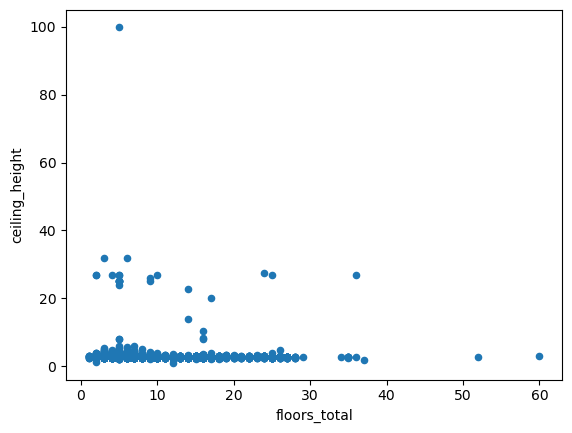

In [61]:
# Визуализируем данные
data.plot(x= 'floors_total', y= 'ceiling_height', kind= 'scatter')

###### Высота потолков: Всего в данном признаке пропущено 38% значений.Среднее значение 2.77. Есть не правдоподобные значения, например значения 1м и 100м. По графику можно увидеть, что высота потолков от этажности зданий не зависит. Очевидно, что все значения выше или ниже стандартного отклонения нужно заменить на медиану.

In [62]:
# Считаем стандартное отклонение параметра
IQR_celling = data['ceiling_height'].describe()[6] - data['ceiling_height'].describe()[4]
standard_deviation_celling_up = data['ceiling_height'].describe()[6] + 1.5 * IQR_celling
standard_deviation_celling_down = data['ceiling_height'].describe()[4] - 1.5 * IQR_celling
print('Доля значений превышающих стандартное отклонение:', data.query('ceiling_height > @standard_deviation_celling_up')['ceiling_height'].count()/len(data))
print('Доля значений меньше стандартного отклонения:', data.query('ceiling_height < @standard_deviation_celling_down')['ceiling_height'].count()/len(data))

Доля значений превышающих стандартное отклонение: 0.034347440820287775
Доля значений меньше стандартного отклонения: 0.0005907422254103549


<AxesSubplot:xlabel='floors_total', ylabel='ceiling_height'>

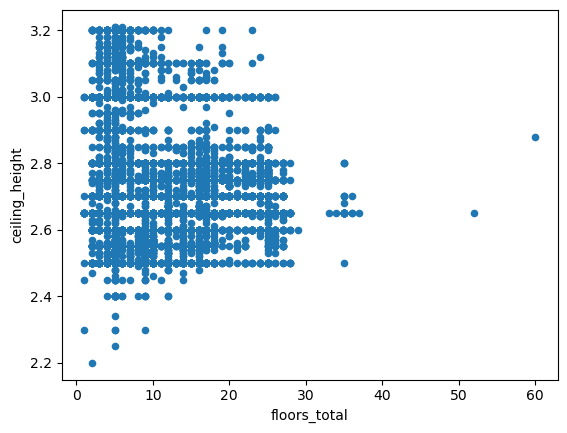

In [63]:
# Меняем значения превышающее стандартное оклонение
data['ceiling_height'] = (
    data['ceiling_height']
    .where(data['ceiling_height'] > standard_deviation_celling_down,
           data['ceiling_height'].describe()[5])
)
data['ceiling_height'] = (
    data['ceiling_height']
    .where(data['ceiling_height'] < standard_deviation_celling_up, 
           data['ceiling_height'].describe()[5])
)
data.plot(x= 'floors_total', y= 'ceiling_height', kind= 'scatter')

In [64]:
data['ceiling_height'].describe()

count    23699.000000
mean         2.667321
std          0.140632
min          2.200000
25%          2.600000
50%          2.650000
75%          2.700000
max          3.210000
Name: ceiling_height, dtype: float64

###### Заменили все пустые значения признака, высота потолков, и значения больше стандартного отклонения на медиану. Медианное значение высоты потолков получилось 2.6м. Среднее так же 2.6.

### 2.2  Количество этажей в доме

In [65]:
# определяем долю пропущеных значений
data['floors_total'].isna().value_counts()[1]/len(data)

0.0036288450989493226

In [66]:
# Выводим описание признака
data['floors_total'].describe()

count    23613.000000
mean        10.673824
std          6.597173
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

###### Количество этажей: пропущено значений 0,4%. Минимальное значение - 1, максимальное - 60. Неправдопообных данных не наблюдается. Прошущенные значения заменять ничем не требуется

### 2.3  Жилая площадь

In [67]:
# определяем долю пропущеных значений
data['living_area'].isna().value_counts()[1]/len(data)

0.08029874678256467

In [68]:
# Выводим описание признака
data['living_area'].describe()

count    21796.000000
mean        34.457852
std         22.030445
min          2.000000
25%         18.600000
50%         30.000000
75%         42.300000
max        409.700000
Name: living_area, dtype: float64

<AxesSubplot:xlabel='total_area', ylabel='living_area'>

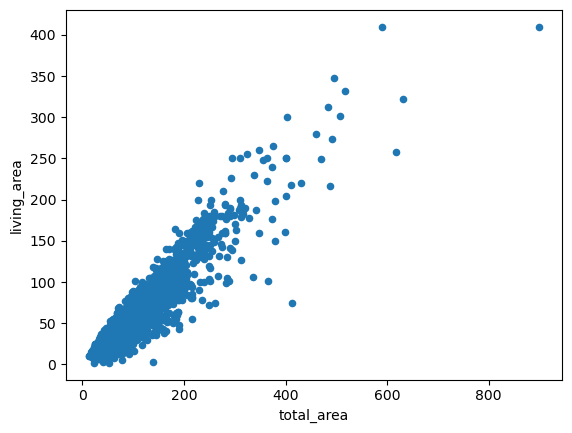

In [69]:
# Визуализируем данные
data.plot(x= 'total_area', y= 'living_area', kind= 'scatter')

In [70]:
# Считаем среднюю долю жилой площади и заполняем пропуски
living_area_ratio = data['living_area'].median()/data['total_area'].median()
data.loc[data['living_area'].isna(),'living_area'] = data['total_area'] * living_area_ratio
data['living_area'].describe()

count    23699.000000
mean        34.624296
std         22.381873
min          2.000000
25%         19.000000
50%         30.000000
75%         42.173077
max        409.700000
Name: living_area, dtype: float64

###### Жилая площадь: пропущено значений 8%. Минимальное значение - 2, максимальное - 409.7 . Из графика наблюдается линейная зависимость жилой площади от общей площади. Значений жилой площади больше общей - нет. Соответсвенно неправдопообных данных не наблюдается. Расчитаем средний коэфициент жилой площади от общей и заполним пропущенные значения значением общей площади умноженным на коэффициент

### 2.4  Площадь кухни

In [71]:
# определяем долю пропущеных значений
data['kitchen_area'].isna().value_counts()[1]/len(data)

0.09612219924891345

In [72]:
# Выводим описание признака
data['kitchen_area'].describe()

count    21421.000000
mean        10.569807
std          5.905438
min          1.300000
25%          7.000000
50%          9.100000
75%         12.000000
max        112.000000
Name: kitchen_area, dtype: float64

In [73]:
# Заменим площадь кухни студий на 0
data.loc[data['studio'] == True,'kitchen_area'] = 0
# Заполним остальные пропущенные значения аналогично как заполняли жилую площадь
kitchen_area_ratio = data['kitchen_area'].median()/data['total_area'].median()
data.loc[data['kitchen_area'].isna(),'kitchen_area'] = data['total_area'] * kitchen_area_ratio
data['kitchen_area'].describe()

count    23699.000000
mean        10.465817
std          6.071440
min          0.000000
25%          7.000000
50%          9.000000
75%         12.000000
max        112.000000
Name: kitchen_area, dtype: float64

<AxesSubplot:xlabel='total_area', ylabel='kitchen_area'>

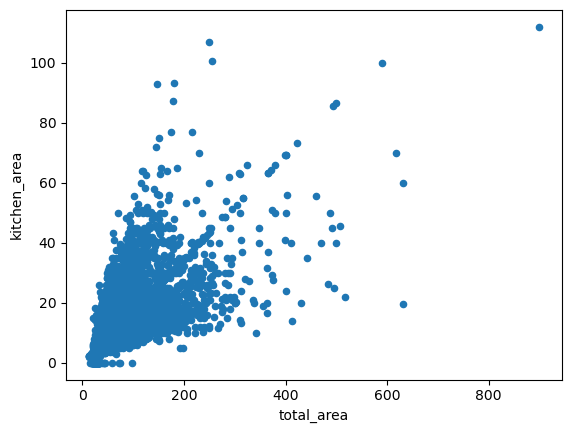

In [74]:
# Визуализируем данные
data.plot(x= 'total_area', y= 'kitchen_area', kind= 'scatter')

###### Площадь кухни: пропущено значений 10%. Минимальное значение - 1.3, максимальное - 112 . Из графика наблюдается линейная зависимость площади кухни от общей площади, но не такая сильная как у жилой площади. Значений площади кухни больше общей - нет. Соответсвенно неправдопообных данных не наблюдается. Заменим площадь кухни в квартирах студиях на ноль. Расчитаем средний коэфициент площади кухни от общей и заполним пропущенные значения значением общей площади умноженным на коэффициент.

### 2.5  Количество балконов

In [75]:
# определяем долю пропущеных значений
data['balcony'].isna().value_counts()[1]/len(data)

0.4860542638929913

In [76]:
# Выводим описание признака
data['balcony'].describe()

count    12180.000000
mean         1.150082
std          1.071300
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max          5.000000
Name: balcony, dtype: float64

In [77]:
# Заменяем пропуски на ноль 
data['balcony'] = data['balcony'].fillna(0)
data['balcony'].isna().value_counts()

False    23699
Name: balcony, dtype: int64

###### Количество балконов: пропущено значений 48%. Неправдопообных данных не наблюдается. Заполним пропущенные значения нулями.

###### 2.6  Название населенного пункта

In [78]:
# определяем долю пропущеных значений
data['locality_name'].isna().value_counts()[1]/len(data)

0.002067597788936242

In [79]:
# Удаляем пропуски
data.dropna(subset=['locality_name'], inplace=True)

In [80]:
data['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

In [81]:
# обрабатываем не явные дубликаты
data['locality_name'] = data['locality_name'].str.replace('городской','')
data['locality_name'] = data['locality_name'].str.replace('посёлок','')
data['locality_name'] = data['locality_name'].str.replace('поселок','')
data['locality_name'] = data['locality_name'].str.replace('городского типа','')
data['locality_name'] = data['locality_name'].str.replace('деревня','')
data['locality_name'] = data['locality_name'].str.replace('садовое товарищество','')
data['locality_name'] = data['locality_name'].str.replace('коттеджный','')
data['locality_name'] = data['locality_name'].str.replace('село','')
data['locality_name'] = data['locality_name'].str.replace('станции','')
data['locality_name'] = data['locality_name'].str.replace('садоводческое некоммерческое товарищество','')
data['locality_name'] = data['locality_name'].str.replace('имени','')
data['locality_name'] = data['locality_name'].str.lstrip()
data['locality_name'].unique()

array(['Санкт-Петербург', 'Шушары', 'Янино-1', 'Парголово', 'Мурино',
       'Ломоносов', 'Сертолово', 'Петергоф', 'Пушкин', 'Кудрово',
       'Коммунар', 'Колпино', 'Красный Бор', 'Гатчина', 'Фёдоровское',
       'Выборг', 'Кронштадт', 'Кировск', 'Новое Девяткино',
       'Металлострой', 'Лебяжье', 'Сиверский', 'Молодцово',
       'Кузьмоловский', 'Новая Ропша', 'Павловск', 'Пикколово',
       'Всеволожск', 'Волхов', 'Кингисепп', 'Приозерск', 'Сестрорецк',
       'Куттузи', 'Аннино', 'Ефимовский', 'Плодовое', 'Заклинье',
       'Торковичи', 'Первомайское', 'Красное Село', 'Понтонный',
       'Сясьстрой', 'Старая', 'Лесколово', 'Новый Свет', 'Сланцы',
       'Путилово', 'Ивангород', 'Шлиссельбург', 'Никольское',
       'Зеленогорск', 'Сосновый Бор', 'Оржицы', 'Кальтино', 'Романовка',
       'Бугры', 'Рощино', 'Кириши', 'Луга', 'Волосово', 'Отрадное',
       'Павлово', 'Оредеж', 'Копорье', 'Молодёжное', 'Тихвин', 'Победа',
       'Нурма', 'Синявино', 'Тосно', 'Стрельна', 'Бокситогорск',

###### Название населенных пунктов: пропущено значений 0,2%. Удалили строки с пропущенными значениями. Обработали неявные дубликаты в названиях населенных пунктов.

### 2.7  Расстояние до центра города

In [82]:
# определяем долю пропущеных значений
data['cityCenters_nearest'].isna().value_counts()[1]/len(data)

0.2330232558139535

In [83]:
# определяем долю пропущеных значений в Санкт-Петербурге
data.query('locality_name == "Санкт-Петербург"')['cityCenters_nearest'].isna().value_counts()[1]/len(data)

0.002579281183932347

###### Расстояние до центра города: всего пропущеных значений 23%. Но в самом городе пропущеных значений 0.25%. Основные значения пропущены в области. Скорее всего в области цена не сильно корелирует с расстоянием до центра города. И ввиду сложности заполнения данных значений, оставим их пустыми.

### 2.8  Аппартаменты

In [84]:
data['is_apartment'] = data['is_apartment'].fillna(value=False)

###### Признак - Аппартаменты, это булево значение. Соответственно пропуски мы заменим на False.

### 2.9  Время показа объявления

In [85]:
# определяем долю пропущеных значений
data['days_exposition'].isna().value_counts()[1]/len(data)

0.13446088794926003

In [86]:
# Заменяем пропуски на 999 и меняем тип данных
data.loc[data['days_exposition'].isna(),'days_exposition'] = 999
data['days_exposition'] = data['days_exposition'].astype('int')
data['days_exposition'].describe()

count    23650.000000
mean       290.775391
std        346.021678
min          1.000000
25%         45.000000
50%        124.000000
75%        390.000000
max       1580.000000
Name: days_exposition, dtype: float64

{'whiskers': [<matplotlib.lines.Line2D at 0x244c061b9d0>,
 'caps': [<matplotlib.lines.Line2D at 0x244c061bf70>,
 'boxes': [<matplotlib.lines.Line2D at 0x244c061b700>],
 'medians': [<matplotlib.lines.Line2D at 0x244c0909550>],
 'fliers': [<matplotlib.lines.Line2D at 0x244c0909820>],
 'means': []}

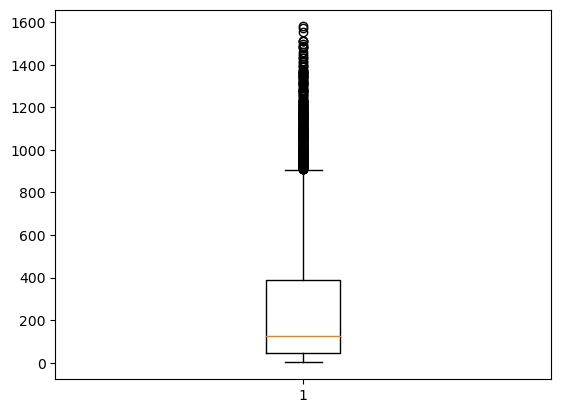

In [87]:
# Визуализируем данные
mpl.pyplot.boxplot(data['days_exposition'])

In [88]:
# Проверяем нулевые значения
data.query('days_exposition == 0')['days_exposition'].count()

0

In [89]:
# Считаем долю значений превышающих стандартное отклонение
IQR = data['days_exposition'].describe()[6] - data['days_exposition'].describe()[4]
standard_deviation = data['days_exposition'].describe()[6] + 1.5 * IQR
data.query('days_exposition > @standard_deviation')['days_exposition'].count()/len(data)

0.15137420718816066

In [90]:
# Выводим описание признака без учета значений превышающих стандартное отклонение
data.query('days_exposition < @standard_deviation')['days_exposition'].describe()

count    20070.000000
mean       162.392427
std        177.658640
min          1.000000
25%         44.000000
50%         92.000000
75%        217.000000
max        907.000000
Name: days_exposition, dtype: float64

###### Время показа объявления: Пропущенных значений 13%. Пропущенные значения заполним значением 999 и переведем в целочисленный тип. Проверка нулевых значений - таковых не выявила. Изучив диаграмму размаха, видим, что имеется 15% значений превышающих стандартное отклонение. Эти данные выглядят не правдоподобными и в будущих расчетах их учитывать не будем. Очистив данные от вбросов получаем: медианное значение - 92 дня, среднее - 162, первая квартиль - 44, третья квартиль - 217.

###### 2.10  Общяя цена объекта

In [91]:
# Посмотрим на самые дорогие объявления
data.sort_values(by = 'last_price').tail(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
8900,13,190870000.0,268.0,2016-03-25,3,2.65,8.0,132.000000,7,False,...,40.000000,0.0,Санкт-Петербург,32440.0,5297.0,0.0,NaN,2.0,198.0,901
5893,3,230000000.0,500.0,2017-05-31,6,2.65,7.0,288.461538,7,False,...,40.000000,0.0,Санкт-Петербург,32440.0,5297.0,0.0,NaN,2.0,198.0,50
13749,7,240000000.0,410.0,2017-04-01,6,2.65,7.0,218.000000,7,False,...,40.000000,0.0,Санкт-Петербург,32440.0,5297.0,0.0,NaN,2.0,198.0,199
16461,17,245000000.0,285.7,2017-04-10,6,2.65,7.0,182.800000,4,False,...,29.800000,0.0,Санкт-Петербург,33143.0,6235.0,3.0,400.0,3.0,140.0,249
22831,18,289238400.0,187.5,2019-03-19,2,2.65,6.0,63.700000,6,False,...,30.200000,0.0,Санкт-Петербург,22494.0,1073.0,3.0,386.0,3.0,188.0,999
15651,20,300000000.0,618.0,2017-12-18,7,2.65,7.0,258.000000,5,False,...,70.000000,0.0,Санкт-Петербург,32440.0,5297.0,0.0,NaN,2.0,198.0,111
1436,19,330000000.0,190.0,2018-04-04,3,2.65,7.0,95.000000,5,False,...,40.000000,0.0,Санкт-Петербург,23011.0,1197.0,3.0,519.0,3.0,285.0,233
14706,15,401300000.0,401.0,2016-02-20,5,2.65,9.0,204.000000,9,False,...,24.000000,3.0,Санкт-Петербург,21912.0,2389.0,1.0,545.0,1.0,478.0,393
19540,8,420000000.0,900.0,2017-12-06,12,2.80,25.0,409.700000,25,False,...,112.000000,0.0,Санкт-Петербург,30706.0,7877.0,0.0,NaN,2.0,318.0,106
12971,19,763000000.0,400.0,2017-09-30,7,2.65,10.0,250.000000,10,False,...,69.307692,2.0,Санкт-Петербург,25108.0,3956.0,1.0,530.0,3.0,756.0,33


###### Видим, что самое дорогое объявление почти в 2 раза дороже ближайшего соседа, хотя квадратура помещения даже меньше. Это безусловно сильно повлияет на показатели дальнейшего исследования. Удалим данное объявление, для корректности исследования

In [92]:
data = data.sort_values(by = 'last_price').drop(12971)
data.sort_values(by = 'last_price').tail(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
19865,20,180000000.0,347.0,2015-01-21,8,2.65,6.0,260.000000,3,False,...,45.0,0.0,Санкт-Петербург,23962.0,3794.0,2.0,537.0,3.0,501.0,834
8900,13,190870000.0,268.0,2016-03-25,3,2.65,8.0,132.000000,7,False,...,40.0,0.0,Санкт-Петербург,32440.0,5297.0,0.0,NaN,2.0,198.0,901
5893,3,230000000.0,500.0,2017-05-31,6,2.65,7.0,288.461538,7,False,...,40.0,0.0,Санкт-Петербург,32440.0,5297.0,0.0,NaN,2.0,198.0,50
13749,7,240000000.0,410.0,2017-04-01,6,2.65,7.0,218.000000,7,False,...,40.0,0.0,Санкт-Петербург,32440.0,5297.0,0.0,NaN,2.0,198.0,199
16461,17,245000000.0,285.7,2017-04-10,6,2.65,7.0,182.800000,4,False,...,29.8,0.0,Санкт-Петербург,33143.0,6235.0,3.0,400.0,3.0,140.0,249
22831,18,289238400.0,187.5,2019-03-19,2,2.65,6.0,63.700000,6,False,...,30.2,0.0,Санкт-Петербург,22494.0,1073.0,3.0,386.0,3.0,188.0,999
15651,20,300000000.0,618.0,2017-12-18,7,2.65,7.0,258.000000,5,False,...,70.0,0.0,Санкт-Петербург,32440.0,5297.0,0.0,NaN,2.0,198.0,111
1436,19,330000000.0,190.0,2018-04-04,3,2.65,7.0,95.000000,5,False,...,40.0,0.0,Санкт-Петербург,23011.0,1197.0,3.0,519.0,3.0,285.0,233
14706,15,401300000.0,401.0,2016-02-20,5,2.65,9.0,204.000000,9,False,...,24.0,3.0,Санкт-Петербург,21912.0,2389.0,1.0,545.0,1.0,478.0,393
19540,8,420000000.0,900.0,2017-12-06,12,2.80,25.0,409.700000,25,False,...,112.0,0.0,Санкт-Петербург,30706.0,7877.0,0.0,NaN,2.0,318.0,106


In [93]:
# Посмотрим на дешевые объявления.
data.sort_values(by = 'last_price').head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
8793,7,12190.0,109.0,2019-03-20,2,2.75,25.0,32.000000,25,False,...,40.500000,0.0,Санкт-Петербург,36421.0,9176.0,1.0,805.0,0.0,NaN,8
17456,7,430000.0,30.4,2019-04-22,1,2.65,2.0,16.000000,1,False,...,6.000000,0.0,Сланцы,NaN,NaN,NaN,NaN,NaN,NaN,999
14911,5,430000.0,54.0,2018-06-26,2,2.65,3.0,31.153846,3,False,...,9.356538,0.0,Свирь,NaN,NaN,NaN,NaN,NaN,NaN,44
16274,18,440000.0,40.0,2018-07-10,1,2.65,5.0,23.076923,1,False,...,6.930769,0.0,Старополье,NaN,NaN,NaN,NaN,NaN,NaN,45
17676,0,450000.0,36.5,2018-02-01,1,2.65,5.0,17.300000,4,False,...,8.500000,1.0,Ям-Тесово,NaN,NaN,NaN,NaN,NaN,NaN,120
9581,7,450000.0,43.4,2018-08-31,2,2.65,5.0,30.300000,3,False,...,5.500000,0.0,Старополье,NaN,NaN,NaN,NaN,NaN,NaN,96
5698,7,450000.0,42.0,2017-07-31,2,2.65,1.0,23.000000,1,False,...,5.800000,0.0,Будогощь,NaN,NaN,NaN,NaN,NaN,NaN,233
16219,14,450000.0,38.5,2018-07-11,2,2.65,2.0,22.211538,1,False,...,6.670865,0.0,Вахнова Кара,NaN,NaN,NaN,NaN,NaN,NaN,45
18867,1,470000.0,41.0,2018-02-11,1,2.65,5.0,32.000000,3,False,...,9.000000,0.0,Выскатка,NaN,NaN,NaN,NaN,NaN,NaN,46
21912,0,470000.0,37.0,2018-02-18,1,2.65,3.0,21.346154,3,False,...,6.410962,0.0,Совхозный,NaN,NaN,NaN,NaN,NaN,NaN,45


###### Посмотрим на дешевые варианты. Первое объявление явный вброс. Удалим его так же как и дорогое.

In [94]:
data = data.sort_values(by = 'last_price').drop(8793)
data.sort_values(by = 'last_price').head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
17456,7,430000.0,30.4,2019-04-22,1,2.65,2.0,16.000000,1,False,...,6.000000,0.0,Сланцы,NaN,NaN,NaN,NaN,NaN,NaN,999
14911,5,430000.0,54.0,2018-06-26,2,2.65,3.0,31.153846,3,False,...,9.356538,0.0,Свирь,NaN,NaN,NaN,NaN,NaN,NaN,44
16274,18,440000.0,40.0,2018-07-10,1,2.65,5.0,23.076923,1,False,...,6.930769,0.0,Старополье,NaN,NaN,NaN,NaN,NaN,NaN,45
17676,0,450000.0,36.5,2018-02-01,1,2.65,5.0,17.300000,4,False,...,8.500000,1.0,Ям-Тесово,NaN,NaN,NaN,NaN,NaN,NaN,120
9581,7,450000.0,43.4,2018-08-31,2,2.65,5.0,30.300000,3,False,...,5.500000,0.0,Старополье,NaN,NaN,NaN,NaN,NaN,NaN,96
5698,7,450000.0,42.0,2017-07-31,2,2.65,1.0,23.000000,1,False,...,5.800000,0.0,Будогощь,NaN,NaN,NaN,NaN,NaN,NaN,233
16219,14,450000.0,38.5,2018-07-11,2,2.65,2.0,22.211538,1,False,...,6.670865,0.0,Вахнова Кара,NaN,NaN,NaN,NaN,NaN,NaN,45
18867,1,470000.0,41.0,2018-02-11,1,2.65,5.0,32.000000,3,False,...,9.000000,0.0,Выскатка,NaN,NaN,NaN,NaN,NaN,NaN,46
21912,0,470000.0,37.0,2018-02-18,1,2.65,3.0,21.346154,3,False,...,6.410962,0.0,Совхозный,NaN,NaN,NaN,NaN,NaN,NaN,45
23484,11,470000.0,44.5,2018-07-02,2,2.65,2.0,28.000000,2,False,...,7.500000,0.0,Сланцы,NaN,NaN,NaN,NaN,NaN,NaN,298


###### Теперь с ценами все в порядке.

### 2.11  Общая площадь

In [95]:
# Посмотрим на маленькие квартиры.
data.sort_values(by = 'total_area').head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
19904,4,2400000.0,12.0,2017-07-19,1,2.55,5.0,10.000000,2,False,...,2.079231,0.0,Санкт-Петербург,21314.0,964.0,1.0,886.0,2.0,45.0,200
19807,0,3800000.0,13.0,2018-07-04,1,2.65,5.0,10.000000,3,False,...,2.252500,0.0,Санкт-Петербург,21302.0,1242.0,1.0,592.0,3.0,27.0,9
19546,3,1850000.0,13.0,2019-03-11,1,2.65,5.0,7.500000,2,False,...,2.252500,0.0,Санкт-Петербург,24915.0,5483.0,1.0,644.0,0.0,NaN,24
17961,3,1400000.0,13.0,2017-12-03,1,2.60,9.0,7.500000,1,False,...,2.252500,0.0,Санкт-Петербург,14350.0,15945.0,0.0,NaN,1.0,185.0,410
19558,2,1686000.0,13.2,2018-12-17,1,2.65,5.0,7.615385,1,False,...,2.287154,0.0,Санкт-Петербург,19891.0,4165.0,1.0,361.0,1.0,155.0,19
19642,5,1190000.0,14.0,2018-07-29,1,2.65,5.0,11.000000,1,False,...,2.000000,0.0,Санкт-Петербург,9898.0,11122.0,0.0,NaN,0.0,NaN,4
12040,5,1900000.0,15.0,2018-06-27,1,2.50,5.0,8.653846,1,False,...,2.599038,0.0,Сосновый Бор,NaN,NaN,NaN,NaN,NaN,NaN,45
16949,9,1550000.0,15.0,2018-08-21,1,2.70,9.0,8.653846,1,False,...,2.599038,0.0,Санкт-Петербург,51048.0,16376.0,0.0,NaN,1.0,1079.0,42
8886,10,2450000.0,15.5,2018-08-22,0,2.65,5.0,10.000000,2,False,...,0.000000,0.0,Санкт-Петербург,24326.0,4589.0,0.0,NaN,1.0,446.0,27
9412,5,2100000.0,16.0,2017-12-10,0,2.65,6.0,13.000000,1,False,...,2.772308,0.0,Санкт-Петербург,20735.0,2111.0,2.0,228.0,3.0,72.0,3


In [96]:
# Посмотрим на большие квартиры.
data.sort_values(by = 'total_area').tail(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
12401,20,91500000.0,495.0,2017-06-19,7,2.65,7.0,347.500000,7,False,...,25.000000,0.0,Санкт-Петербург,NaN,5735.0,2.0,110.0,0.0,NaN,14
5893,3,230000000.0,500.0,2017-05-31,6,2.65,7.0,288.461538,7,False,...,40.000000,0.0,Санкт-Петербург,32440.0,5297.0,0.0,NaN,2.0,198.0,50
15016,8,150000000.0,500.0,2016-01-13,4,3.20,7.0,288.461538,7,False,...,86.634615,0.0,Санкт-Петербург,33058.0,6150.0,3.0,209.0,3.0,531.0,303
8018,20,84000000.0,507.0,2015-12-17,5,2.65,7.0,301.500000,7,True,...,45.500000,1.0,Санкт-Петербург,NaN,5735.0,2.0,110.0,0.0,NaN,1078
4237,1,50000000.0,517.0,2017-10-14,7,2.65,4.0,332.000000,3,False,...,22.000000,0.0,Санкт-Петербург,22835.0,1847.0,2.0,477.0,2.0,540.0,999
5358,20,65000000.0,590.0,2019-02-14,15,2.65,6.0,409.000000,3,False,...,100.000000,0.0,Санкт-Петербург,24447.0,4666.0,1.0,767.0,0.0,NaN,14
15651,20,300000000.0,618.0,2017-12-18,7,2.65,7.0,258.000000,5,False,...,70.000000,0.0,Санкт-Петербург,32440.0,5297.0,0.0,NaN,2.0,198.0,111
3117,19,140000000.0,631.0,2019-03-30,7,2.65,5.0,364.038462,5,False,...,60.000000,0.0,Санкт-Петербург,25707.0,4972.0,0.0,NaN,2.0,210.0,999
12859,20,140000000.0,631.2,2019-04-09,7,2.65,4.0,322.300000,4,False,...,19.500000,1.0,Санкт-Петербург,25707.0,4972.0,0.0,NaN,2.0,210.0,999
19540,8,420000000.0,900.0,2017-12-06,12,2.80,25.0,409.700000,25,False,...,112.000000,0.0,Санкт-Петербург,30706.0,7877.0,0.0,NaN,2.0,318.0,106


In [97]:
# Количество объявлений, с площадью более 200м
len(data.query('total_area > 200'))

226

In [98]:
# 169 штук не превысит 10% - удаляем
data = data.drop(index= data.loc[(data['total_area'] > 200)].index)

In [99]:
# количество объявлений, с ценой более 50и млн.
len(data.query('last_price > 50000000'))

50

In [100]:
# Удаляем
data = data.drop(index= data.loc[(data['last_price'] > 50000000)].index)

###### Самая большая квартира в полтора раза больше чем ближайший сосед. И не смотря на адекватную цену такую квартиру лучше удалить из выборки так как она утянет параметры исследования в большую сторону

### 2.12  Число комнат

In [101]:
# Посмотрим на многокомнатные варианты
data.sort_values(by = 'rooms').tail(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
22420,12,25000000.0,196.0,2016-11-04,7,2.65,6.0,145.000000,5,False,...,17.000000,1.0,Санкт-Петербург,25083.0,3658.0,1.0,552.0,0.0,NaN,999
17350,18,25000000.0,134.0,2016-12-01,7,2.65,6.0,104.000000,2,False,...,11.200000,0.0,Санкт-Петербург,25257.0,6060.0,1.0,761.0,1.0,584.0,278
14603,12,13490000.0,100.6,2018-07-31,7,2.65,4.0,58.038462,2,True,...,17.430885,0.0,Санкт-Петербург,24309.0,3876.0,3.0,574.0,3.0,325.0,50
2261,15,17800000.0,164.0,2019-02-12,7,2.65,7.0,125.900000,7,False,...,12.000000,0.0,Санкт-Петербург,20139.0,2670.0,2.0,41.0,3.0,397.0,999
23555,5,15350000.0,158.5,2019-03-07,7,2.95,7.0,57.400000,7,False,...,12.400000,1.0,Санкт-Петербург,23546.0,3088.0,1.0,347.0,0.0,NaN,999
750,9,29500000.0,188.8,2017-03-04,7,2.70,2.0,119.300000,1,False,...,10.200000,0.0,Санкт-Петербург,20965.0,814.0,0.0,NaN,2.0,267.0,246
4435,13,22190000.0,191.2,2017-12-05,8,2.90,6.0,115.800000,1,False,...,5.000000,0.0,Санкт-Петербург,21589.0,1152.0,1.0,587.0,2.0,155.0,115
8758,5,16100000.0,150.0,2018-07-10,8,2.92,5.0,107.000000,1,False,...,7.200000,0.0,Санкт-Петербург,26080.0,4782.0,2.0,473.0,0.0,NaN,999
9688,8,33000000.0,194.1,2017-02-07,11,2.65,5.0,129.000000,2,False,...,11.900000,0.0,Санкт-Петербург,21469.0,1015.0,1.0,686.0,2.0,66.0,813
648,3,17500000.0,183.7,2018-07-01,11,2.65,7.0,138.800000,7,False,...,13.300000,0.0,Санкт-Петербург,23606.0,3148.0,0.0,NaN,0.0,NaN,999


###### Данные выглядят адекватно. Так как последний вариант выбивается не сильно и вместе с числом комнат линейно растет площадь и цена

In [102]:
# Посмотрим на варианты с 0 комнат. В квартирах студиях заменим параметр на 1. Остальное удалим.
data.loc[(data['rooms'] == 0) & (data['studio'] == True), 'rooms'] = 1
data = data.drop(index= data.loc[(data['rooms'] == 0)].index)

### 2.13  Кухни

In [103]:
# Удалим большие кухни (> 40м:2). 
data = data.drop(index= data.loc[(data['kitchen_area'] > 40)].index)

###### В квартирах студиях заменим параметр на 1. Остальное удалим

In [104]:
# Убираем явные дубликаты
data = data.drop_duplicates()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23229 entries, 17456 to 4910
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23229 non-null  int64         
 1   last_price            23229 non-null  float64       
 2   total_area            23229 non-null  float64       
 3   first_day_exposition  23229 non-null  datetime64[ns]
 4   rooms                 23229 non-null  int64         
 5   ceiling_height        23229 non-null  float64       
 6   floors_total          23145 non-null  float64       
 7   living_area           23229 non-null  float64       
 8   floor                 23229 non-null  int64         
 9   is_apartment          23229 non-null  bool          
 10  studio                23229 non-null  bool          
 11  open_plan             23229 non-null  bool          
 12  kitchen_area          23229 non-null  float64       
 13  balcony      

In [105]:
# Проверяем обработанную таблицу
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23229.000000,2.322900e+04,23229.000000,23229.000000,23229.000000,23145.000000,23229.000000,23229.000000,23229.000000,23229.000000,17734.000000,17754.000000,17755.000000,7819.000000,17755.000000,8817.000000,23229.000000
mean,9.827931,5.813005e+06,57.760010,2.039089,2.665811,10.710521,33.170191,5.893667,10.076779,0.592148,28833.356096,14333.509012,0.599324,492.743062,0.757477,521.591471,288.344397
std,5.658160,4.493314e+06,25.742761,0.980051,0.139501,6.599849,17.052711,4.885997,4.677008,0.959307,12710.937918,8597.413614,0.789976,342.495756,0.929281,277.694602,344.480930
min,0.000000,4.300000e+05,12.000000,1.000000,2.200000,1.000000,2.000000,1.000000,0.000000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.600000,5.000000,19.000000,2.000000,7.000000,0.000000,18488.500000,9508.500000,0.000000,288.000000,0.000000,299.000000,45.000000
50%,9.000000,4.600000e+06,51.500000,2.000000,2.650000,9.000000,30.000000,4.000000,9.000000,0.000000,26815.000000,13188.000000,0.000000,456.000000,0.000000,505.000000,123.000000
75%,14.000000,6.628500e+06,68.100000,3.000000,2.700000,16.000000,42.000000,8.000000,11.700000,1.000000,37407.000000,16365.500000,1.000000,613.000000,1.000000,733.000000,385.000000
max,50.000000,5.000000e+07,200.000000,11.000000,3.210000,60.000000,164.700000,33.000000,40.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


In [106]:
# Проверка процента удаленных данных 
(len(pd.read_csv('real_estate_data.csv', sep= '\t', decimal='.')) - len(data)) / (len(pd.read_csv('real_estate_data.csv', sep= '\t', decimal='.')))

0.019832060424490486

###### Общий вывод часть 2: Была проведена предоброботка данных. Были удалены явные и не явные дубликаты. Были обработаны пропуски и не правдоподобные значения в девяти признаках. Были оставлены пропуски в семи признаках: общее количество этажей, расстояние до аэропорта, расстояние до центра (так как данные трудно заменить. необходимо указать на это разработчикам). И признаки, расстояния до парков, и прудов так же не трогали, так как они не будут участвовать в дальнейшем исследовании.

## 3. Посчитаем и добавим в таблицу новые столбцы

In [109]:
# добавление столбца с ценой квадратного метра
data['sqm_price'] = (data['last_price'] / data['total_area']).astype(int)

In [110]:
# Добавляем столбцы дня недели, месяца и года
data['weekday'] = data['first_day_exposition'].dt.weekday
data['month'] = data['first_day_exposition'].dt.month
data['year'] = data['first_day_exposition'].dt.year

In [111]:
# Добавляем столбец с типом этажа
data.loc[data['floor'] == 1,'floor_type'] = 'первый'
data.loc[data['floor'] == data['floors_total'],'floor_type'] = 'последний'
data.loc[data['floor_type'].isna(),'floor_type'] = 'другой'


In [113]:
# Перевели расстояние до центра в километры и сделали значения целочисленными. заполнили нулями пропущенные значения
data['cityCenters_nearest'] = (data['cityCenters_nearest'] / 1000).fillna(value=0).astype(int)

### 4. Исследовательский анализ данных

### 4.1  Общая площадь.

            count
total_area       
12.0            1
13.0            3
13.2            1
14.0            1
15.0            2
...           ...
198.0           2
198.1           1
198.9           1
199.2           1
200.0           3

[1992 rows x 1 columns]


count    23229.000000
mean        57.760010
std         25.742761
min         12.000000
25%         40.000000
50%         51.500000
75%         68.100000
max        200.000000
Name: total_area, dtype: float64

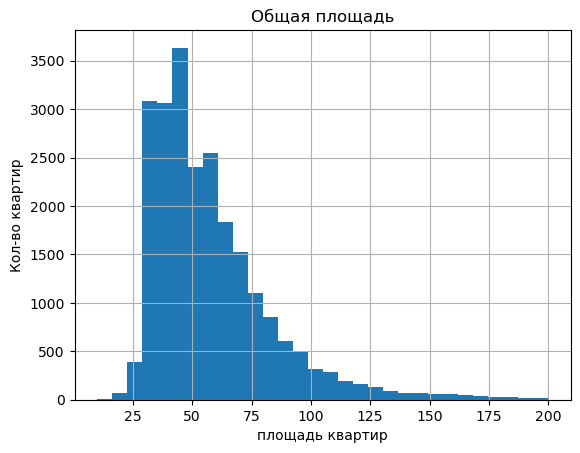

In [114]:
# Построим гимтограмму и сводную таблицу
data.hist('total_area', bins=30, range=(10,200))
plt.title('Общая площадь')
plt.xlabel('площадь квартир')
plt.ylabel('Кол-во квартир')
print(data.pivot_table(index= 'total_area', values= 'floor_type', aggfunc= 'count').sort_values(by = 'total_area').rename(columns= {'floor_type': 'count'}))
data['total_area'].describe()

###### Наблюдения: Наименьшая по площади продаваемая квартира 12м^2. Наибольшая по площади продаваемая квартира 200м^2. Больше всего объявлений с квартирами 45м^2. Большинство продаваемых квартир менее 100м^2. График напоминает нормальное распределение.

###### 4.2  Жилая площадь.

             count
living_area       
164.700000       1
30.080000        1
30.057692        1
30.050000        1
56.120000        1
...            ...
20.000000      474
16.000000      484
30.000000      598
17.000000      669
18.000000      871

[2255 rows x 1 columns]


count    23229.000000
mean        33.170191
std         17.052711
min          2.000000
25%         19.000000
50%         30.000000
75%         42.000000
max        164.700000
Name: living_area, dtype: float64

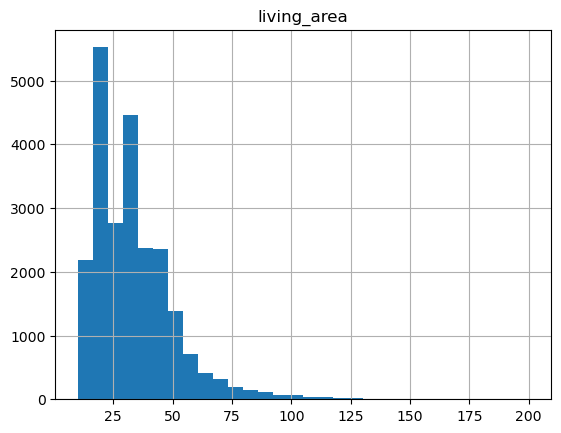

In [115]:
# Построим гимтограмму и сводную таблицу
data.hist('living_area', bins=30, range=(10,200))
print(data.pivot_table(index= 'living_area', values= 'floor_type', aggfunc= 'count').rename(columns= {'floor_type': 'count'}).sort_values(by = 'count'))
data['living_area'].describe()

###### Наблюдения: Наименьшая по жилой площади продаваемая квартира 2м^2. Наибольшая по жилой площади продаваемая квартира 164м^2. В большинстве продаваемых квартир жилая площадь менее 75 м^2. На графике видны 2 всплеска: больше всего продается квартир с жилой площадью 15-20м^2 и 30м^2. Но при этом квартир с жилой площадью 25м:2 продается гораздо меньше.

###### 4.3  Площадь кухни

              count
kitchen_area       
10.89             1
11.37             1
11.39             1
25.90             1
11.42             1
...             ...
7.00           1062
9.00           1100
8.00           1108
10.00          1255
6.00           1298

[1529 rows x 1 columns]


count    23229.000000
mean        10.076779
std          4.677008
min          0.000000
25%          7.000000
50%          9.000000
75%         11.700000
max         40.000000
Name: kitchen_area, dtype: float64

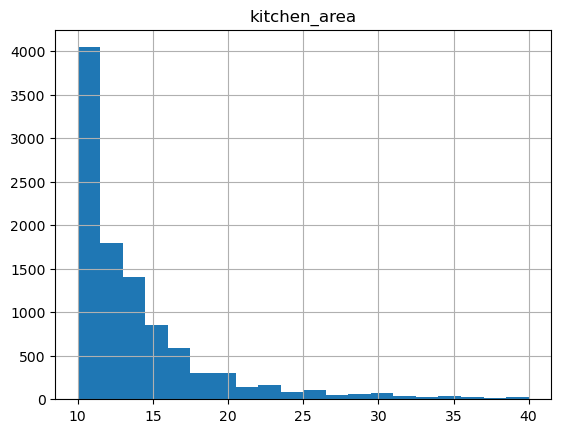

In [116]:
# Построим гимтограмму и сводную таблицу
data.hist('kitchen_area', bins=20, range=(10,40))
print(data.pivot_table(index= 'kitchen_area', values= 'floor_type', aggfunc= 'count').rename(columns= {'floor_type': 'count'}).sort_values(by = 'count'))
data['kitchen_area'].describe()

###### Наблюдения: Наименьшая по площади кухни продаваемая квартира 0м^2. Это как мы выяснили ранее квартиры студии Наибольшая по площади кухни продаваемая квартира 40м^2. В подавляющем большинстве продаваемых квартир площадь кухни от 6 до 15м^2. График напоминает нормальное распределение

### 4.4 Цена объекта

            count
last_price       
430000.0        2
440000.0        1
450000.0        4
470000.0        3
480000.0        1
...           ...
48000000.0      2
48763000.0      1
49000000.0      1
49900000.0      2
50000000.0      5

[2806 rows x 1 columns]


count    2.322900e+04
mean     5.813005e+06
std      4.493314e+06
min      4.300000e+05
25%      3.400000e+06
50%      4.600000e+06
75%      6.628500e+06
max      5.000000e+07
Name: last_price, dtype: float64

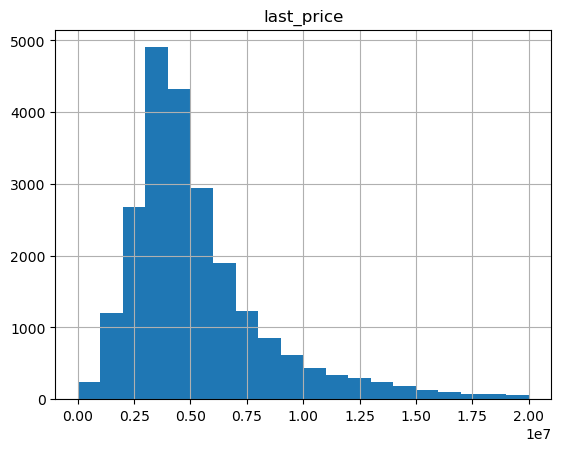

In [117]:
# Построим гимтограмму и сводную таблицу
data.hist('last_price', bins=20, range=(10,20000000))
print(data.pivot_table(index= 'last_price', values= 'floor_type', aggfunc= 'count').rename(columns= {'floor_type': 'count'}).sort_values(by = 'last_price'))
data['last_price'].describe()

###### Наблюдения: Наименьшая по цене продаваемая квартира 430т. руб. Эта цена выглядит нормальной для минимума. Наибольшая по цене продаваемая квартира 50млн. руб. В основном квартиры продают по цене от 1 до 10и млн руб. График напоминает нормальное распределение

### 4.4  Количество комнат

       count
rooms       
1       8170
2       7892
3       5719
4       1104
5        259
6         61
7         20
8          2
11         2


count    23229.000000
mean         2.039089
std          0.980051
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         11.000000
Name: rooms, dtype: float64

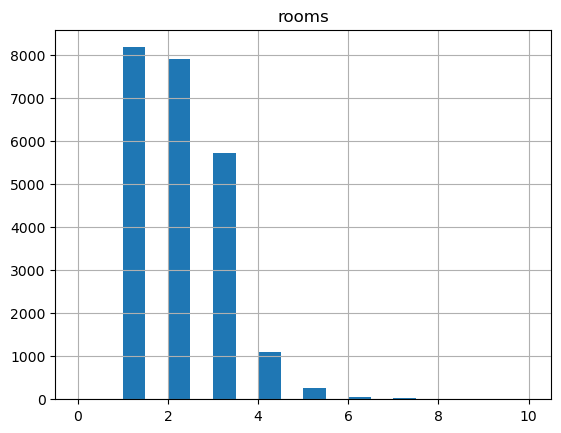

In [118]:
# Построим гимтограмму и сводную таблицу
data.hist('rooms', bins=20, range=(0,10))
print(data.pivot_table(index= 'rooms', values= 'floor_type', aggfunc= 'count').rename(columns= {'floor_type': 'count'}).sort_values(by = 'rooms'))
data['rooms'].describe()

###### Наблюдения: Менее всего комнат в квартирах студиях. Больше всего комнат в продаваемой квартире - 11. Больше всего продают 1-2 комнатные квартиры по 8000 объявлений. 3х комнатных меньше их около 6000.

### 4.5  Высота потолков

                count
ceiling_height       
2.20                1
2.25                1
2.34                1
2.99                1
2.49                1
...               ...
3.00             1065
2.70             1564
2.60             1643
2.50             3512
2.65            10371

[81 rows x 1 columns]


count    23229.000000
mean         2.665811
std          0.139501
min          2.200000
25%          2.600000
50%          2.650000
75%          2.700000
max          3.210000
Name: ceiling_height, dtype: float64

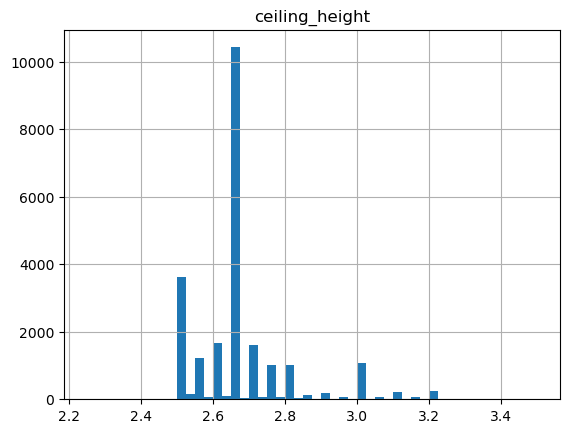

In [119]:
# Построим гимтограмму и сводную таблицу
data.hist('ceiling_height', bins=50, range=(2.25,3.5))
print(data.pivot_table(index= 'ceiling_height', values= 'floor_type', aggfunc= 'count').rename(columns= {'floor_type': 'count'}).sort_values(by = 'count'))
data['ceiling_height'].describe()

###### Наблюдения: Данный признак уже предобработан. Вбросы и не корректные значения исправлены. Наименьшее значение высоты потолков - 2.2м. Наибольшее - 3.2м. Есть два пика на графике: около 4000 квартир продаются с потолкам 2.5м и более 10000 с потолками 2.65м.

### 4.6  Этаж квартиры

       count
floor       
1       2890
2       3293
3       3006
4       2724
5       2562
6       1271
7       1187
8       1068
9       1039
10       679
11       515
12       518
13       374
14       334
15       339
16       308
17       221
18       175
19       143
20       109
21       122
22       111
23        98
24        61
25        43
26        23
27        10
28         1
29         1
30         1
31         1
32         1
33         1


count    23229.000000
mean         5.893667
std          4.885997
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         33.000000
Name: floor, dtype: float64

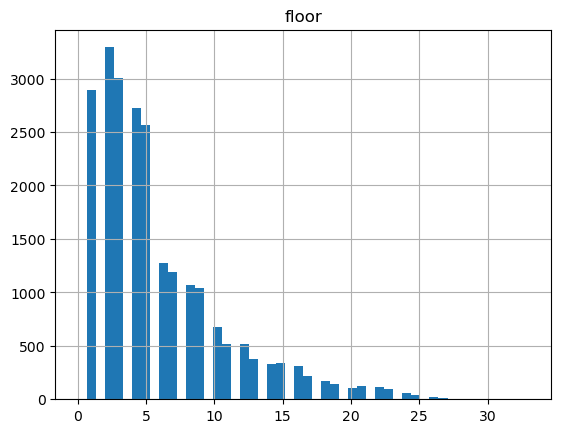

In [120]:
# Построим гимтограмму и сводную таблицу
data.hist('floor', bins=50, range=(0,33))
print(data.pivot_table(index= 'floor', values= 'floor_type', aggfunc= 'count').rename(columns= {'floor_type': 'count'}).sort_values(by = 'floor'))
data['floor'].describe()

###### Наблюдения: Менее всего вартир продается на высоких этажах от 22 и выше. Видимо связано это с тем что высотных зданий не так много. Большинство квартир продается на этажах с 1 по 10.

### 4.7  Тип этажа квартиры

In [121]:
# Построим гимтограмму и сводную таблицу
data.pivot_table(index= 'floor_type', values= 'locality_name', aggfunc= 'count').rename(columns= {'locality_name': 'count'})

,count
floor_type,
другой,17110
первый,2865
последний,3254


###### Наблюдения: Наибольшее количество продаваемых квартир находятся не на первом и не на последнем этажах. Первый и последний этажи расположились примерно поровну(по 3000 объявлений)

### 4.8  Общее количество этажей в доме

              count
floors_total       
1.0              25
2.0             374
3.0             649
4.0            1150
5.0            5681
6.0             848
7.0             560
8.0             354
9.0            3734
10.0           1164
11.0            199
12.0           1348
13.0            224
14.0            545
15.0            364
16.0           1364
17.0            825
18.0            498
19.0            336
20.0            260
21.0            156
22.0            283
23.0            348
24.0            456
25.0           1061
26.0            123
27.0            163
28.0             21
29.0              1
33.0              1
34.0              1
35.0             23
36.0              3
37.0              1
52.0              1
60.0              1


count    23145.000000
mean        10.710521
std          6.599849
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

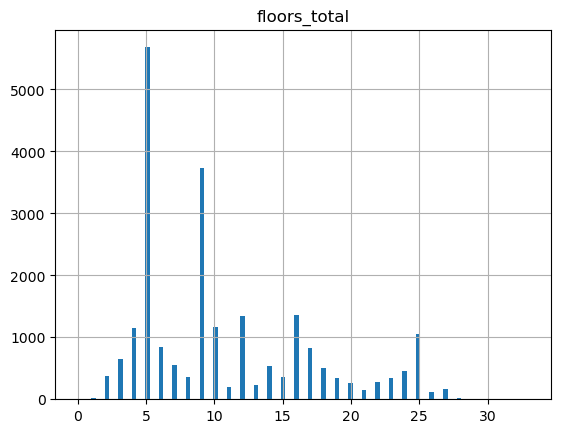

In [122]:
# Построим гимтограмму и сводную таблицу
data.hist('floors_total', bins=100, range=(0,33))
print(data.pivot_table(index= 'floors_total', values= 'floor_type', aggfunc= 'count').rename(columns= {'floor_type': 'count'}).sort_values(by = 'floors_total'))
data['floors_total'].describe()

###### Наблюдения: Как и ожидалось, большинство квартир продается в пяти, девяти и двенадцати этажных домах. Но так же есть всплески 16 и 25 этажных домов. Если первые относятся к советскому стандарту домостроения. То последние - это популярный современный формат.

### 4.9  Расстояние до центра города в метрах

                     count
cityCenters_nearest       
38                       1
61                       1
60                       1
56                       1
64                       1
...                    ...
13                    1390
11                    1408
14                    1496
12                    1506
0                     5548

[61 rows x 1 columns]


count    23229.000000
mean        10.575832
std          9.540583
min          0.000000
25%          2.000000
50%         11.000000
75%         15.000000
max         65.000000
Name: cityCenters_nearest, dtype: float64

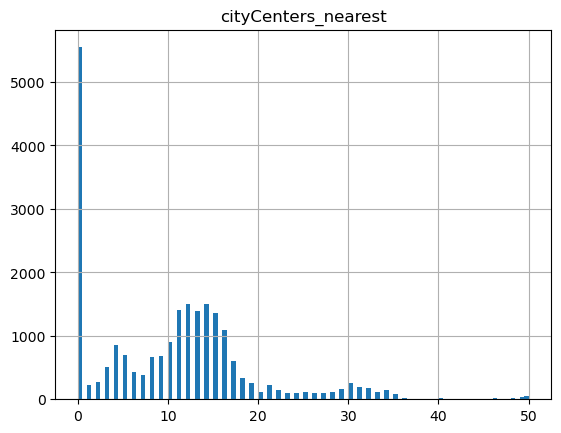

In [123]:
# Построим гимтограмму и сводную таблицу
data.hist('cityCenters_nearest', bins=100, range=(0,50))
print(data.pivot_table(index= 'cityCenters_nearest', values= 'floor_type', aggfunc= 'count').rename(columns= {'floor_type': 'count'}).sort_values(by = 'count'))
data['cityCenters_nearest'].describe()

###### Наблюдения: Большое количество значений параметра равно нулю, но как выяснилось ранее это пропущенные значения которые вовсе не относятся к городу. Наибольшее количество квартир продаются на расстоянии от 3 до 16и километров от цетнтра. Наибольшее расстояне - 65километров.

### 4.10  Расстояние до ближайшего аэропорта

                  count
airports_nearest       
62                    1
78                    1
75                    1
83                    1
70                    2
...                 ...
14                  568
13                  584
24                  625
18                  647
0                  5496

[73 rows x 1 columns]


count    23229.000000
mean        21.620130
std         16.379962
min          0.000000
25%         10.000000
50%         21.000000
75%         34.000000
max         84.000000
Name: airports_nearest, dtype: float64

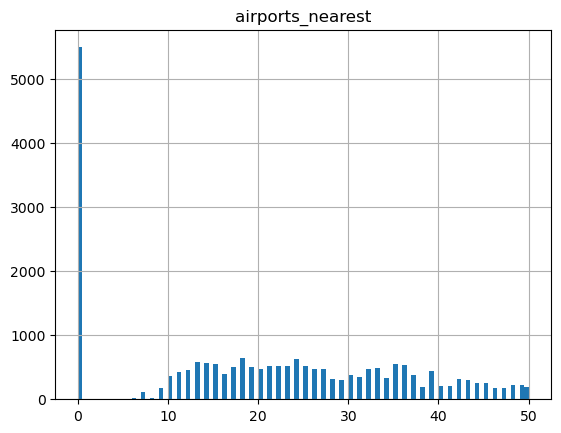

In [124]:
# переведем метры в километры. Построим гимтограмму и сводную таблицу
data['airports_nearest'] = (data['airports_nearest'] / 1000).fillna(value=0).astype(int)
data.hist('airports_nearest', bins=100, range=(0,50))
print(data.pivot_table(index= 'airports_nearest', values= 'floor_type', aggfunc= 'count').rename(columns= {'floor_type': 'count'}).sort_values(by = 'count'))
data['airports_nearest'].describe()

###### Наблюдения: Большое количество значений параметра равно нулю, но как выяснилось ранее это пропущенные значения. Наибольшее количество квартир продаются на расстоянии от 3 до 45и километров от цетнтра. Наибольшее расстояне - 84километра.

### 4.11  Расстояние до ближайшего парка

               count
parks_nearest       
1.0                1
116.0              1
941.0              1
932.0              1
929.0              1
...              ...
471.0             31
456.0             39
173.0             40
392.0             41
441.0             67

[989 rows x 1 columns]


count    7819.000000
mean      492.743062
std       342.495756
min         1.000000
25%       288.000000
50%       456.000000
75%       613.000000
max      3190.000000
Name: parks_nearest, dtype: float64

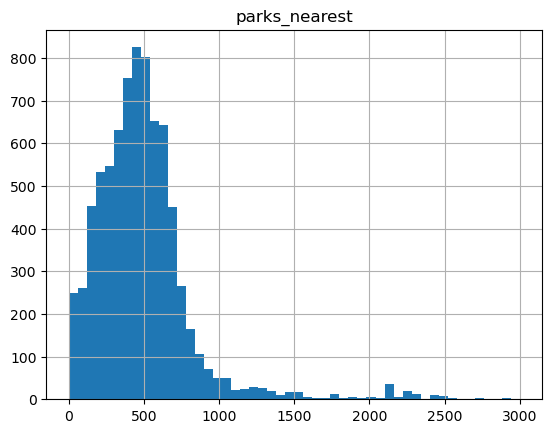

In [125]:
data.hist('parks_nearest', bins=50, range=(0,3000))
print(data.pivot_table(index= 'parks_nearest', values= 'floor_type', aggfunc= 'count').rename(columns= {'floor_type': 'count'}).sort_values(by = 'count'))
data['parks_nearest'].describe()

###### Наблюдения: Наибольшее количество квартир публикуются в будние дни со вторника по пятницу, примерно по 4тысячи . В понедельник немного меньше 3500. В выходные наблюдается спад - менее 2000

### 4.12  Как быстро продавались квартиры

array([[<AxesSubplot:title={'center':'days_exposition'}>]], dtype=object)

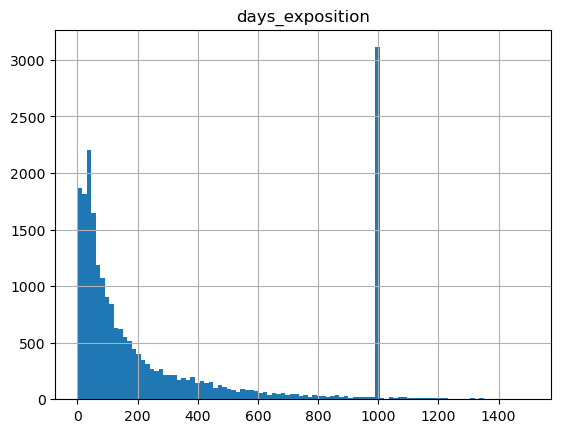

In [126]:
#Построим гистограмму
data.hist('days_exposition', bins=100, range=(1,1500))

###### На графике виден вброс. Но это мы заменили нулевые значения на 999. Но есть данные и выше 1000 дней, они выглядят не правдоподобно. Поэтому отбросим данные выше Q3+1.5IQR(расчитали на этапе предобработки)

In [127]:
# Выведем описание столбца с учетом отброшенных данных
data.query('days_exposition < @standard_deviation')['days_exposition'].describe()

count    19756.000000
mean       161.460113
std        176.734423
min          1.000000
25%         44.000000
50%         92.000000
75%        216.000000
max        906.000000
Name: days_exposition, dtype: float64

###### Медианное значение срока продажи - 92 дня, среднее - 162, первая квартиль - 44, третья квартиль - 216. Быстрой продажей можно считать срок менее первой квартили (<44 дней). Медленной можно считать выше третьей(> 216 дней).

### 4.13  Какие факторы больше всего влияют на общую (полную) стоимость объекта

0.7624208327537897

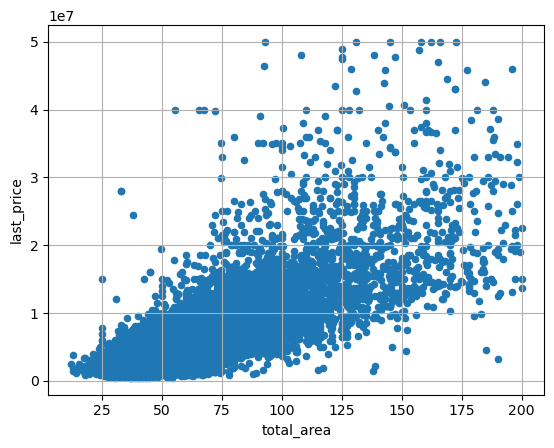

In [128]:
# зависимость цены от общей площади
data.plot(x= 'total_area', y= 'last_price', kind= 'scatter', grid = True)
data['total_area'].corr(data['last_price'])

###### Зависимость цены от общей площади: Коэффициент кореляции Пирсона - 0.76. Это означает что существует прямая зависимость цены от площади. То же подтверждается и графиком.

0.665971089299828

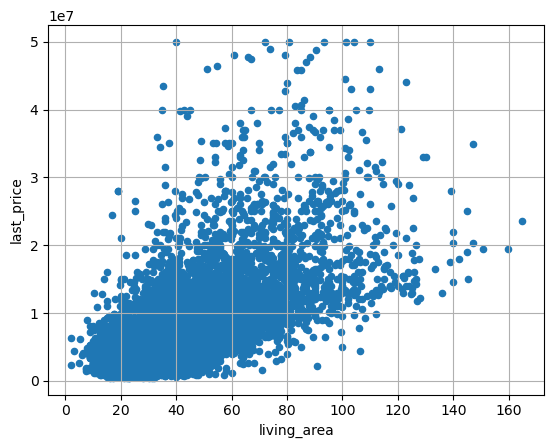

In [129]:
# зависимость цены от жилой площади
data.plot(x= 'living_area', y= 'last_price', kind= 'scatter', grid = True)
data['living_area'].corr(data['last_price'])

###### Зависимость цены от жилой площади так же существует, хотя коэффициент кореляции Пирсона меньше чем у общей площади - 0,66. В целом график похож на тот, что мы строили для общей площади.

0.5856405699499172

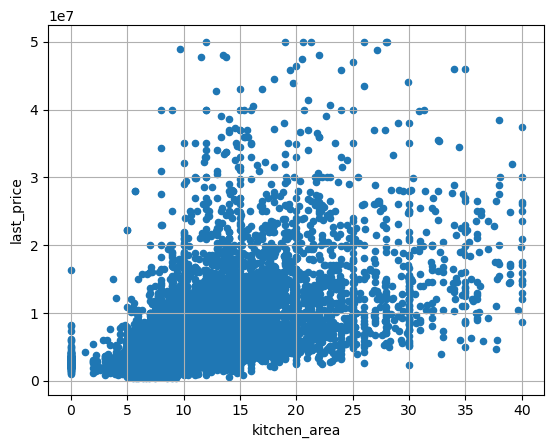

In [130]:
#зависимость цены от площади кухни
data.plot(x= 'kitchen_area', y= 'last_price', kind= 'scatter', grid = True)
data['kitchen_area'].corr(data['last_price'])

###### Зависимость цены от площади кухни меньше чем зависимость от общей и жилой площадей. Коэффициент кореляции Пирсона - 0,58. График так же подтверждает это.

0.47400934751276314

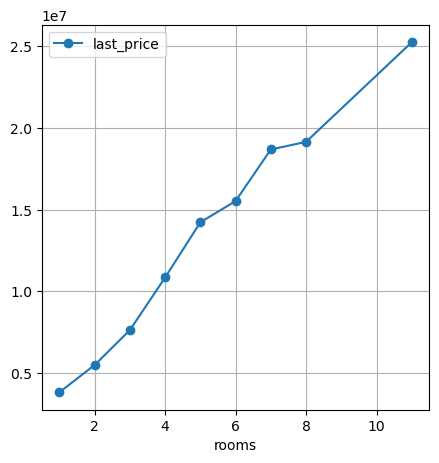

In [131]:
#зависимость цены от количества комнат
data.pivot_table(index='rooms', values='last_price').plot(grid=True, style='o-', figsize=(5, 5))
data['rooms'].corr(data['last_price'])

###### Зависимость цены от количества комнаттак же существует. Коэффициент кореляции Пирсона - 0,47. На графике так же прослеживается линейная зависимость. Чем больше комнат, тем больше цена.

<AxesSubplot:xlabel='floor_type'>

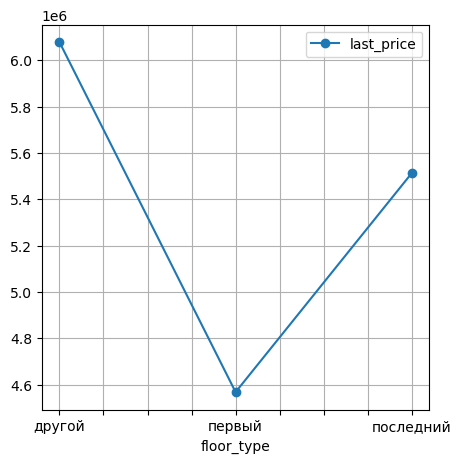

In [132]:
#зависимость цены от этажа, на котором расположена квартира
data.pivot_table(index='floor_type', values='last_price').plot(grid=True, style='o-', figsize=(5, 5))

###### Зависимость цены от этажа, на котором расположена квартира: На графике наблюдается прямая зависимость цены от этажа. Первый этаж самый дешевый. Последний - дороже первого. И самые дорогие расположились посередине.

<AxesSubplot:xlabel='year'>

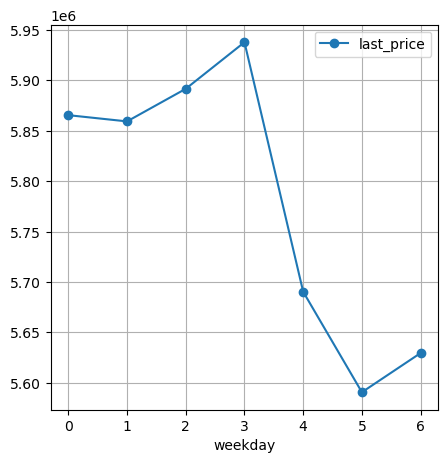

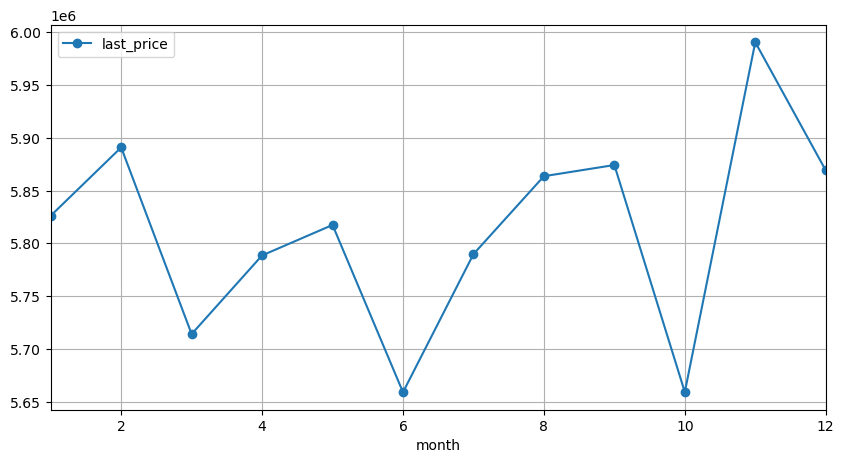

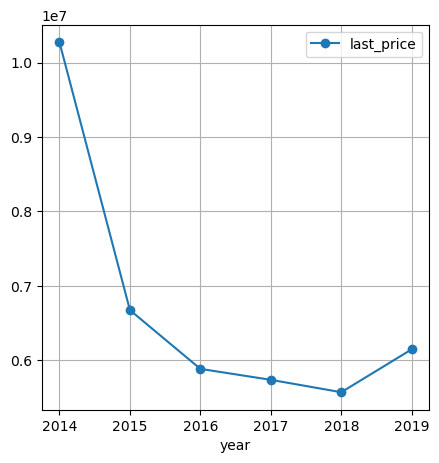

In [133]:
# Зависимость от дня размещения
data.pivot_table(index='weekday', values='last_price').plot(grid=True, style='o-', figsize=(5, 5))

# Зависимость от месяца размещения
data.pivot_table(index='month', values='last_price').plot(grid=True, style='o-', xlim=(1,12), figsize=(10, 5))

# Зависимость от года размещения
data.pivot_table(index='year', values='last_price').plot(grid=True, style='o-', figsize=(5, 5))

###### День недели: Определенной зависимости цены от дня недели не прослеживается. Самые дорогие опубликованы в середине недели, самые дешевые - в конце.
###### Месяц: По году колебания цен расположились следущим образом: Месяцы с дорогими объявлениями - Февраль, Май, Сентябрь. С дешевыми - Февраль, Март, Июнь, Октябрь. Вероятно это связано с общей деловой активностью, которая в начале года и летом находится на низком уровне.
###### Год: Квартиры очень сильно подешевели в 2015-2018 годах, что, вероятно, вызвано некоторым кризисом 2014-2015 годов. В 2019 году цены снова стали повышаться, так как регуляторная политика ЦБ в этот момент была достаточно мягкая.

### 5.1  Расчет средней цены одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений

In [135]:
# Сравниваем среднюю стоимость квадратного метра в топ-10 городов по числу объявлений
city_top_ten = data['locality_name'].value_counts().head(10)
city_top_ten_sqm_price = (
    data.query('locality_name in (@city_top_ten.index)')
    .pivot_table(index='locality_name', values='sqm_price')
    .sort_values('sqm_price', ascending=False)
    .astype(int)
)
city_top_ten_sqm_price

,sqm_price
locality_name,
Санкт-Петербург,111926
Пушкин,102901
Кудрово,95298
Парголово,90348
Мурино,85923
Шушары,78702
Колпино,75332
Гатчина,68745
Всеволожск,68654


###### Вывод: Наибольшая средняя стоимость квадратного метра, как и ожидалось, в Санкт-Петербурге. На втором месте раположился Пушкин. Скорее всего это связано с исторической привлекательностью данного города, и большого потока туристов. Далее идут города, фактически являющиеся частью Санкт-Петербурга. Наименьшая стоимость квадратного метра у Выборга, который значително удален от столицы региона.

### 5.2  Оценка изменения стоимости объектов в зависимости от расстояния до центра города

<AxesSubplot:xlabel='cityCenters_nearest'>

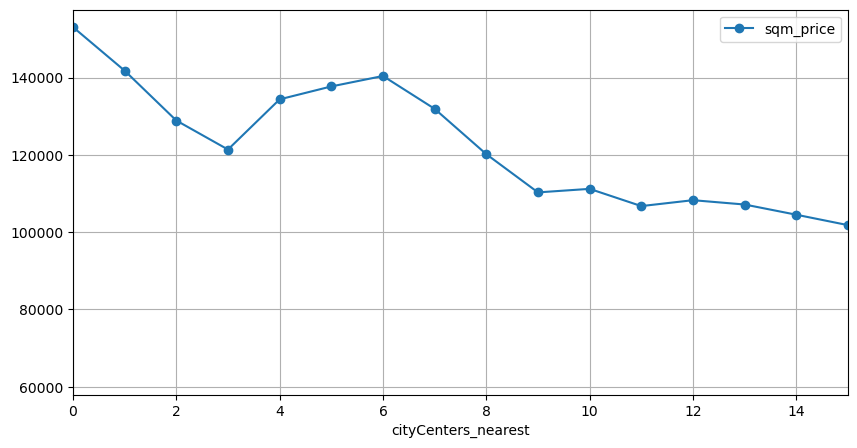

In [136]:
(
    data.query('locality_name == "Санкт-Петербург"')
    .pivot_table(index='cityCenters_nearest', values='sqm_price')
    .sort_values('cityCenters_nearest')
    .plot(grid=True, style='o-', xlim=(0,15), figsize=(10, 5))
)

###### Вывод: Как и ожидалось цена квадратного метра имеет обратную зависимость от расстояния до центра города. Самый дорогой квадратный метр в центре города, более 150 тысяч рублей. Далее стоимость метра пропорционально падает, и на границе города составляет 100 тысяч рублей. Существует локальный всплеск стоимости на 6м километре. Возможно там расположился район с элитной недвижимостью.

# Общий вывод

##### В данной работе был проведен исследовательский анализ данных объявлений о продаже недвижимости в г. Санкт-Петербург. Были проанализированы 23440 объявлений. Проведена предобработка данных. Были удалены явные и не явные дубликаты, обработаны пропуски и не правдоподобные значения в тринадцати признаках.
##### Посчитаны дополнительные признаки, cтоимость квадратного метра, тип этажа квартиры. Медианные значания продаваемых квартир: площадь 52м^2, цена - 4,6млн, количество комнат - 2, высота полтолков -2,65, стоимость квадратного метра -94т.р.
##### Был проведен исследовательский анализ данных. Определены сроки продажи квартир: Чаще всего квартиры продают за 92 дня, быстрой продажей можно считать срок менее 44 дней, медленной - больше 217 дней. Медианное значение срока продажи - 92 дня.
##### Изучили факторы, наиболее влияющие на общую стоимость квартир. Выяснилось, что на стоимость квартир больше всего влияет площадь квартир и этаж, на котором она расположена. Количество комнат так же имеет линейную звисимость.
##### Посчитали среднюю стоимость квадратного метра по городам. Как и ожидалось самая большая в Санкт-Петербурге(>113т.р.) и прилегающих к нему городах(> 75 т.р.). Оценили изменение стоимости квадратного метра по удалению от центра города. Как и ожидалось цена квадратного метра имеет обратную зависимость от расстояния до центра города. Самый дорогой квадратный метр в центре - более 160 тысяч рублей, и на границе города составляет 100 тысяч рублей.